In [5]:
import numpy as np
import os
from sklearn.cluster import MiniBatchKMeans
import json
import random
import networkx as nx
import matplotlib.pyplot as plt

np.random.seed(1)
random.seed(1)

In [6]:
import numpy as np
import sys

class CIBR(object):
    def __init__(self, dataset, n_branches, depth):
        self.dataset = dataset
        self.n_branches = n_branches
        self.depth = depth
        self.tree = {}
        self.nodes = {}
        self.leaves = {}
        
        # private:
        self._current_index = 0
        
        # build graph
        self.fit()
        self.graph = nx.DiGraph()
        for k, v in self.tree.items():
            self.graph.add_node(k)
        for link in v:
            self.graph.add_edge(k, link)
        return
    
    def extract_features(self, image=None):
        # dummy features to test
        # replace with Antonio's 
        if (image is None):
            ones = np.ones(1)
#             return np.array([ones, ones * 2, ones * 10, ones * 11])
            return np.random.randn(5000, 128)
        else:
            return sift(image)

    def get_image_id(self, image_path):
        """
        Given an image path, returns the id of the image: the numerical part of the filename
        Args:
            image_path (str): path of the image
        Returns:
            (str): the id of the image as string
        """
        return os.path.splitext(os.path.basename(image_path))[0]
    
    def weight(self, leafId):
        """
        Calculates the weight associated to a specific node based on entropy.
        w_i = ln(number of images in the tree / number of images in the node)
        Args:
            nodeId (int): the id of the node to calculate the weight on
        Returns:
            (float) the weight of the node
        """
        return np.log(len(self.dataset) / len(self.leaves[leafId]))

    def fit(self, features=None, node=0, root=None, current_depth=0):
        """
        Generates a hierarchical vocabulary tree representation of some input features
        using hierarchical k-means clustering.
        This function populates two class fields:
            `self.tree`, as Dict[int, List[int]], where the key is the id of the root node
        and the value is a list of children nodes, and
             `self.nodes` as a dictionary Dict[int, numpy.ndarray] that stores the actual value for each node
        Args:
            features (numpy.ndarray): a two dimensional vector of input features where dim 0 is samples and dim 1 is features
            node (int): current node id to set
            root (numpy.ndarray): the value of the parent of the `node` as a virtual feature
            current_depth (int): the depth of the node as the distance in jumps from the very root of the tree
        Returns:
            (Dict[int], List[int]): A dictionary of nodesID with the corresponding children
        """
        if features is None:
            features = self.extract_features()
        if root is None:
            root = np.mean(features)
        
        self.nodes[node] = root
        
        # if `node` is a leaf node, return
        if current_depth >= self.depth or len(features) < self.n_branches:
            # initialise leaves
            self.leaves[node] = {}
            return
        
        # group features by cluster
        model = MiniBatchKMeans(n_clusters=self.n_branches)
        model.fit(features)
        children = [[] for i in range(self.n_branches)]
        for i in range(len(features)):
            children[model.labels_[i]].append(features[i])
        
        # cluster children
        self.tree[node] = []
        for i in range(self.n_branches):
            self._current_index += 1
            self.tree[node].append(self._current_index)
            self.fit(children[i], self._current_index, model.cluster_centers_[i], current_depth + 1, )
        return

    def propagate(self, image_path):
        """
        Returns the frequency-inverse document frequency (tfidf) of the image in the tree.
        Note that we are propagating using only the frequency in the leaf node.
        Args:
            image_path (str): path of the image to encode
        Return:
            (numpy.ndarray): The encoded image
        """
        graph = nx.DiGraph()
        points, features = self.extract_features(image_path)
        image_id = self.get_image_id(image_path)
        for feature in features:
            path = self.encode(feature)
            leafId = path[-1]
            graph = self.add_path(graph, path, image_id)
            if image_id in self.leaves[leafId]:
                self.leaves[leafId][image_id] += 1
            else:
                self.leaves[leafId][image_id] = 1
        return graph

    def encode_feature(self, feature, node=0, return_leaf_only=False):
        """
        Propagates a feature, down the tree, and returns the closest node.
        Note that we are returning only the leaf, and not the entire path.
        Args:
            feature (numpy.ndarray): The feature to lookup
            root (int): Node id to start the search from.
                        Default is 0, meaning the very root of the tree
        """
        min_dist = float("inf")
        path = [node]
        while len(self.tree[node]) != 0:  #recur
            for child in self.tree[node]:
                distance = np.linalg.norm([self.nodes[child] - feature])  # l1 norm 
                if distance < min_dist:
                    min_dist = distance
                    node = child
                    path.append(child)
        return node if return_leaf_only else path
    
    def encode(self, image_path):
        """
        Encodes an image into a set of paths on the tree.
        The vector representation is the values list of a key value pair,
        where the key is the id of the node and the value is the number of times that node is visited during propagation.
        This results into an tf-idf scheme.
        Args:
            image_path (str): the path of the image
        Returns:
            (Tuple[networkx.DiGraph, numpy.ndarray): A tuple, where the first element is the graph containing all the paths
                                                     and the second is the vector built using the tf-idf scheme.
        """
        graph = nx.DiGraph()
        features = self.extract_features(image_path)
        for feature in features:
            path = self.encode_feature(feature)
            self.add_path(graph, path)
        return graph

    def scores(self, query_path):
        """
        Scores the current query image against the images in the database
        Args:
            query (numpy.ndarray): Query image
        Returns:
            (Dict): the score of the query image against all the database images 
        """
        scores = {}
        for image_path in self.dataset.all_images:  # for each database image
            imageId = self.get_image_id(image_path)
            scores[imageId] = 0
#             for leafId in self.leaves:

    def score(self, database_image_path, query_image_path):
        """
        Measures the similatiries between the set of paths of the features of each image.
        """
        db_id = self.get_image_id(database_image_path)
        query_id = self.get_image_id(query_image_path)
        
        # propagate the images down the tree
        d_graph = self.encode_image(database_image_path)
        q_graph = self.encode_image(query_image_path)
        
        # get the nodes of the tree
        d_encoded = np.array(d_graph)
        q_graph = np.array(q_graph)
        
        # score using the l2 norm
        score = 2 - 2 * np.sum()
                
    def add_path(self, graph, path, image_id):
        for i in range(len(path)):
            node = path[i]
            
            # this automatically skips if node is already there, so attributes are preserved
            graph.add_node(node)
            
            # add tfidf
            if image_id not in graph.nodes[node]:
                graph.nodes[node][image_id] = 1
            else:
                graph.nodes[node][] += 1
                
            if i != len(path) - 2:
                graph.add_path(path[i], path[i + 1])
        return
        

In [7]:
vv3 = CIBR(None, 10, 6)
vv3.fit()
# print(vv3.tree)
# print(vv3.nodes)

{0: [1, 22, 443, 534, 1125, 1376, 1847, 2328, 2639, 2760],
 1: [2, 3, 4, 5, 16, 17, 18, 19, 20, 21],
 5: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 22: [23, 24, 85, 86, 107, 108, 169, 210, 271, 312],
 24: [25, 26, 27, 28, 39, 50, 51, 52, 53, 84],
 28: [29, 30, 31, 32, 33, 34, 35, 36, 37, 38],
 39: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
 53: [54, 75, 76, 77, 78, 79, 80, 81, 82, 83],
 54: [55, 56, 57, 68, 69, 70, 71, 72, 73, 74],
 57: [58, 59, 60, 61, 62, 63, 64, 65, 66, 67],
 86: [87, 88, 89, 100, 101, 102, 103, 104, 105, 106],
 89: [90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
 108: [109, 110, 151, 152, 153, 154, 165, 166, 167, 168],
 110: [111, 112, 113, 114, 125, 136, 137, 138, 139, 140],
 114: [115, 116, 117, 118, 119, 120, 121, 122, 123, 124],
 125: [126, 127, 128, 129, 130, 131, 132, 133, 134, 135],
 140: [141, 142, 143, 144, 145, 146, 147, 148, 149, 150],
 154: [155, 156, 157, 158, 159, 160, 161, 162, 163, 164],
 169: [170, 171, 182, 183, 184, 185, 186, 187, 208, 209],
 171: [172, 173

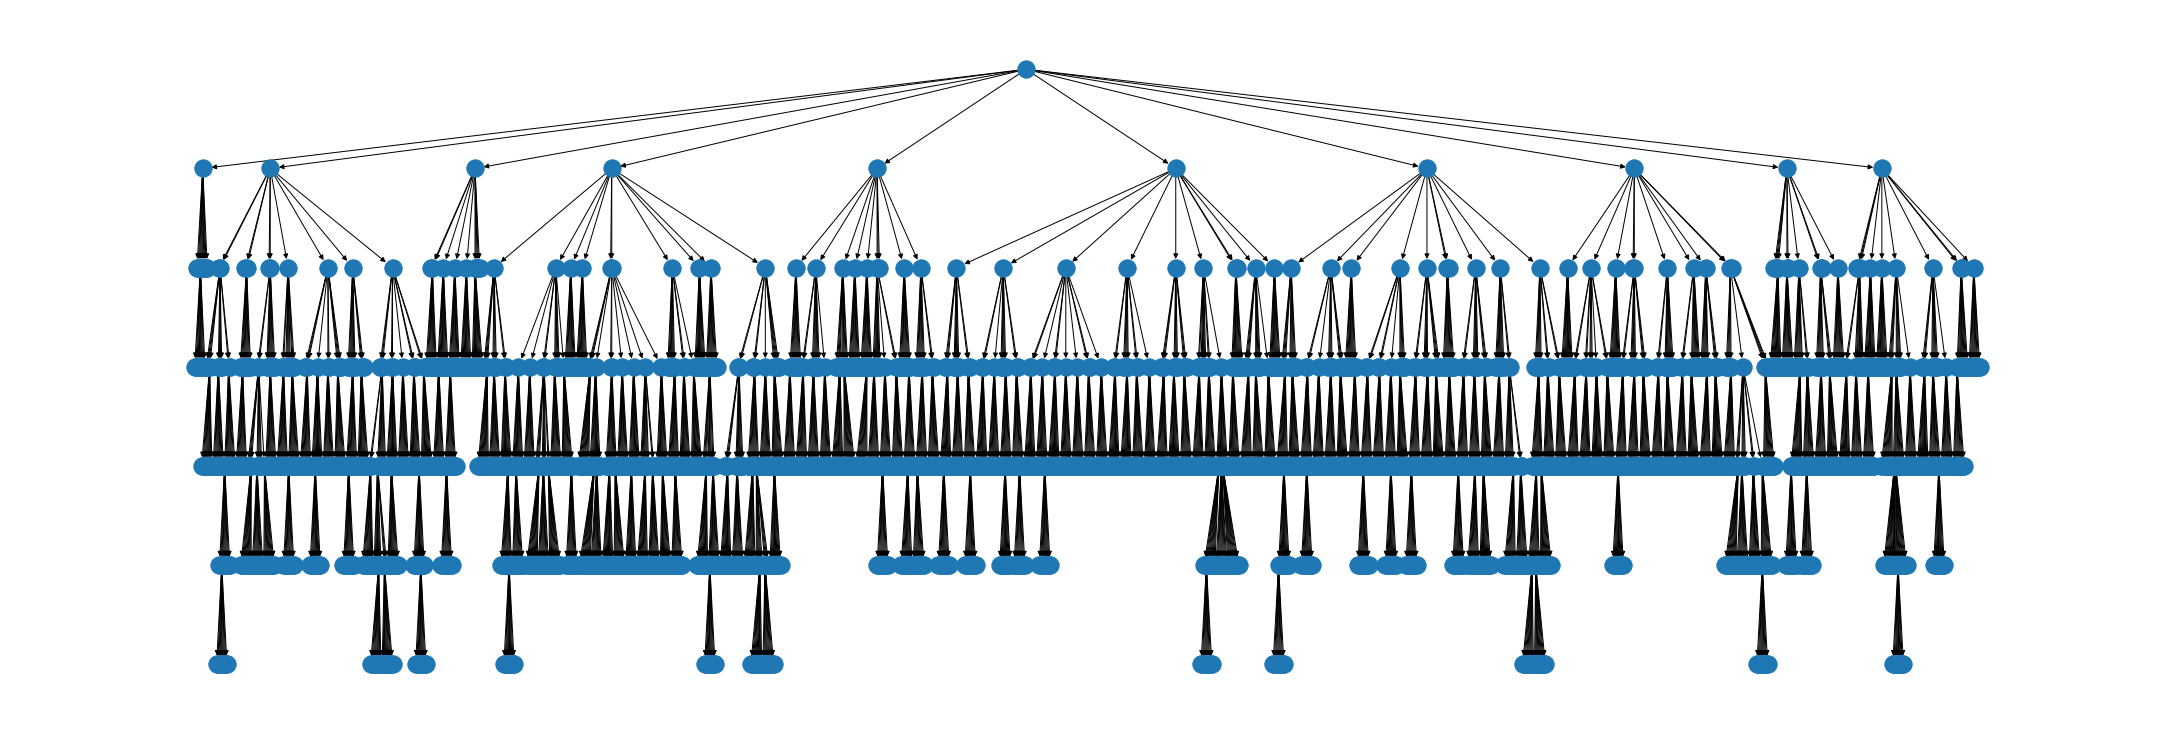

In [8]:
graph = nx.DiGraph()
for k, v in vv3.tree.items():
    graph.add_node(k)
    for link in v:
        graph.add_edge(k, link)

plt.figure(figsize=(30, 10))
pos = nx.drawing.nx_agraph.graphviz_layout(graph, prog='dot')
nx.draw(graph, pos=pos)

In [30]:
sorted(list(a))

[-5, 0, 1]

In [44]:
a.add_node(-5)
a.add_edge(0, 1)

In [31]:
np.array(a)

array([ 0,  1, -5])

In [59]:
a.add_node(0)

In [56]:
a.add_node(0, tfidf=a.nodes[0]["tfidf"] + 1)

In [60]:
a.nodes.data()

NodeDataView({0: {'tfidf': 3}, 1: {}, -5: {}})

In [58]:
"tfidf" in a.nodes[0]

True

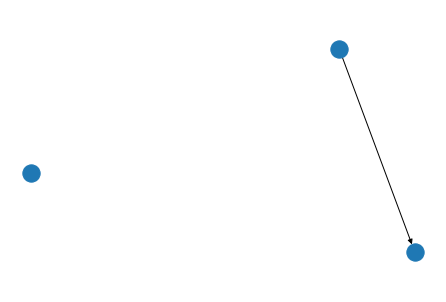

In [46]:
nx.draw(a)